In [35]:
import pandas as pd
# Save processed feature sets and labels for next notebook
X_train_sel = pd.read_csv(r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\data\processed\X_train_selected.csv', index_col=0)
X_test_sel = pd.read_csv(r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\data\processed\X_test_selected.csv', index_col=0)
y_train = pd.read_csv(r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\data\processed\y_train.csv')
y_test = pd.read_csv(r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\data\processed\y_test.csv')

# 04 Model Training, Tuning, and Evaluation

In this section, we systematically train, tune, and evaluate three powerful classification algorithms:
- **Random Forest (RF)**: Robust to overfitting and effective for large, noisy datasets.
- **Support Vector Machine (SVM)**: Strong theoretical foundation and works well even when classes are not linearly separable.
- **XGBoost**: An efficient implementation of gradient boosting, excellent for handling imbalanced and complex datasets.

Each model will undergo hyperparameter tuning using cross-validation. We will then compare their performance using a suite of classification metrics and visualization tools.

## 4.1 Import Required Libraries

We import all the necessary modules for model training, hyperparameter search, and evaluation.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 4.2 Define Cross-Validation Strategy

We use Stratified K-Fold cross-validation to ensure that each fold maintains the relative class proportions, which is especially important for imbalanced datasets.

In [31]:
# Define a stratified 5-fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4.3 Random Forest: Hyperparameter Tuning and Training

We perform hyperparameter tuning for the Random Forest classifier using RandomizedSearchCV, searching over a range of tree depths, number of trees, and minimum samples per split.

In [36]:
# Set the hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform randomized search with cross-validation
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=10, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1, random_state=42
)
rf_search.fit(X_train_sel, y_train)

print("Random Forest best params:", rf_search.best_params_)
rf_best = rf_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\555555\anaconda3\envs\bropt\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}


## 4.4 Support Vector Machine: Hyperparameter Tuning and Training

We tune the SVM using RandomizedSearchCV, testing different kernel types, penalty parameters, and gamma settings. Probability estimates are enabled for ROC analysis.

In [37]:
# Hyperparameter grid for SVM
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=42)

# Perform randomized search with cross-validation
svm_search = RandomizedSearchCV(
    svm, svm_params, n_iter=8, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1, random_state=42
)
svm_search.fit(X_train_sel, y_train)

print("SVM best params:", svm_search.best_params_)
svm_best = svm_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\555555\anaconda3\envs\bropt\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM best params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}


## 4.5 XGBoost: Hyperparameter Tuning and Training

We tune XGBoost with a range of boosting rounds, tree depths, and learning rates, leveraging its strength in capturing non-linear feature interactions.

In [38]:
# Hyperparameter grid for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Perform randomized search with cross-validation
xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=10, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1, random_state=42
)
xgb_search.fit(X_train_sel, y_train)

print("XGBoost best params:", xgb_search.best_params_)
xgb_best = xgb_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\555555\anaconda3\envs\bropt\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:56:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}


## 4.6 Model Evaluation: Classification Reports and Confusion Matrices

We evaluate the three tuned classifiers using detailed classification reports (accuracy, precision, recall, F1-score) and confusion matrices to visualize misclassifications.

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)  # y_train should be your actual target labels
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

C:\Users\555555\anaconda3\envs\bropt\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\555555\anaconda3\envs\bropt\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\555555\anaconda3\envs\bropt\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00       128
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00        14

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



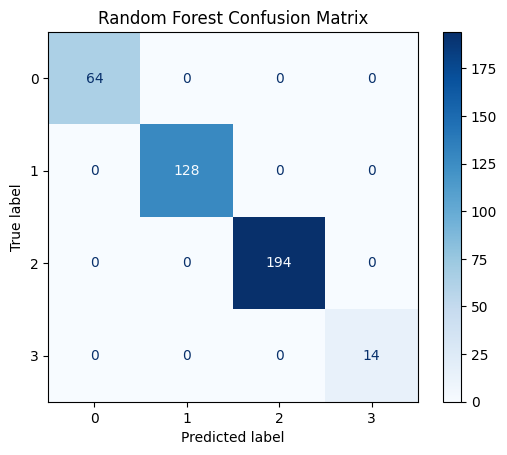


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00       128
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00        14

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



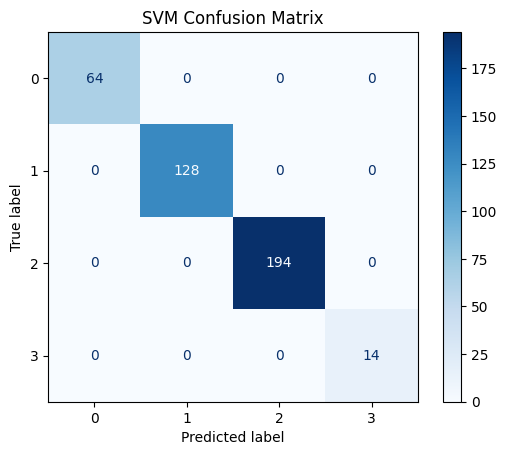


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00       128
           2       1.00      0.99      1.00       194
           3       0.93      1.00      0.97        14

    accuracy                           1.00       400
   macro avg       0.98      1.00      0.99       400
weighted avg       1.00      1.00      1.00       400



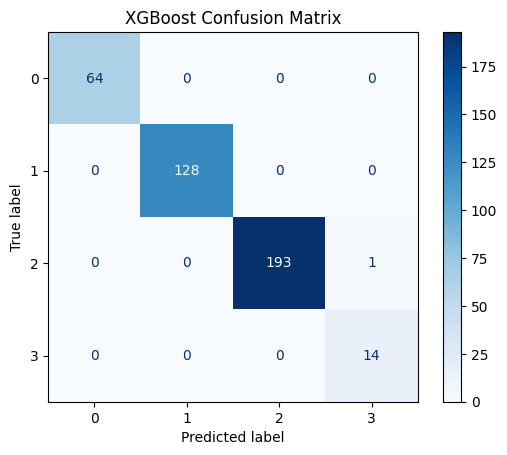

In [43]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Random Forest": rf_best,
    "SVM": svm_best,
    "XGBoost": xgb_best
}

class_names = [str(c) for c in le.classes_]  # Convert to strings

for name, model in models.items():
    y_pred = model.predict(X_test_sel)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=class_names))

    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_sel,
        y_test_enc,
        display_labels=class_names,
        cmap='Blues'
    )
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [44]:
print(type(le))


<class 'sklearn.preprocessing._label.LabelEncoder'>


## 4.7 Multiclass ROC Curves

We plot one-vs-rest ROC curves for each class and model, providing a visual assessment of the classifiers’ ability to distinguish each disease category.

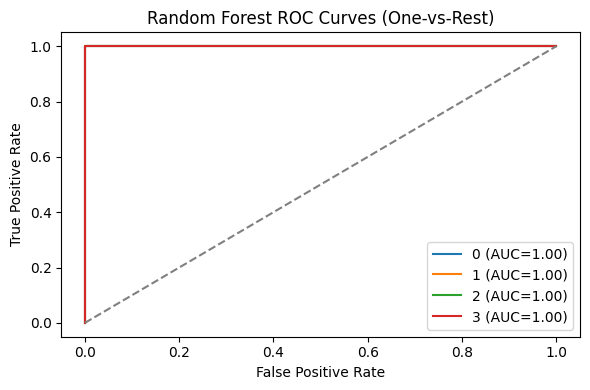

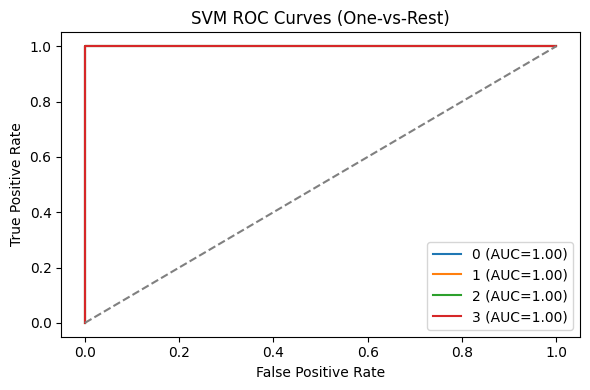

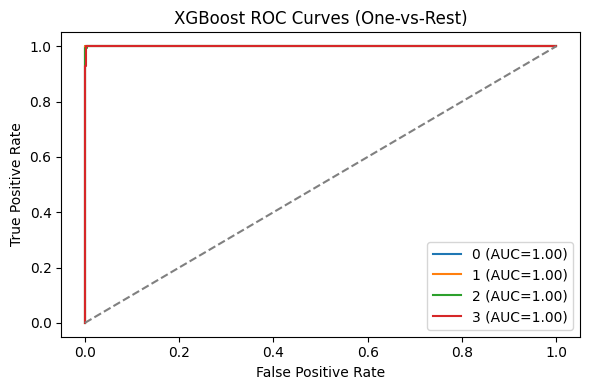

In [45]:
from sklearn.preprocessing import label_binarize

# Binarize the multiclass labels for ROC computation
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

for name, model in models.items():
    y_score = model.predict_proba(X_test_sel)
    plt.figure(figsize=(6,4))
    for i, class_name in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC={auc:.2f})')
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.title(f"{name} ROC Curves (One-vs-Rest)")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4.8 Model Comparison Summary

We summarize the findings, highlighting the strengths and potential applications of each classifier based on the results.

In [47]:
print("Summary:")
for name, model in models.items():
    y_pred = model.predict(X_test_sel)
    acc = np.mean(y_pred == y_test_enc)
    print(f"{name}: Test Accuracy = {acc:.3f}")

Summary:
Random Forest: Test Accuracy = 1.000
SVM: Test Accuracy = 1.000
XGBoost: Test Accuracy = 0.998


In [49]:
import joblib
# Save the best models
joblib.dump(rf_best, r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\outputs\rf_best_model.pkl')
joblib.dump(svm_best, r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\outputs\svm_best_model.pkl')
joblib.dump(xgb_best, r'C:\Users\555555\Malaria-Typhoid-ML-Diagnosis\outputs\xgb_best_model.pkl')

['C:\\Users\\555555\\Malaria-Typhoid-ML-Diagnosis\\outputs\\xgb_best_model.pkl']